In [1]:
#import libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt #data viz
import seaborn as sns #data viz
from sklearn.compose import ColumnTransformer #data preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler #data preprocessing
from sklearn.impute import KNNImputer #handle missing values
from sklearn.model_selection import train_test_split #train/test dataset
from tensorflow.keras import layers, models #neural network architecture
from tensorflow.keras.metrics import BinaryAccuracy #model evaluation
from tensorflow.keras.callbacks import EarlyStopping #regularization
from tensorflow import keras #keras
import tensorflow as tf #tensorflow
from sklearn.metrics import accuracy_score, recall_score, precision_score #evaluate model
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [2]:
#Read In Dataset
pd.set_option('display.max_columns', None)
url = "https://raw.githubusercontent.com/onezmy/Heart-Failure/main/heart.csv"
heart_data = pd.read_csv(url)
heart_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
#display percent of dataset with heart disease
perc_dis = heart_data['HeartDisease'].sum() / len(heart_data)
print('Percent of patients in dataset with heart disease:', round(perc_dis, 4))

Percent of patients in dataset with heart disease: 0.5534


In [4]:
#Creates lists of the columns based on the data type/how data should be visualized
#catagorical variables
cat_vars = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']
#numeric variables
num_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
#label
label = 'HeartDisease'

In [5]:
#Creates functions for plotting variables 

#function for plotting catagoric variables as a bar chart
def display_barchart(data, var, label):
    #calculates the count of patients in each catagory vs heart disease
    grp = data.groupby([var, label])[var].count().unstack().reset_index()

    labels = list(grp.iloc[:, 0].values)
    no_dis = list(grp.iloc[:, 1].values) #no heart disease patients
    yes_dis = list(grp.iloc[:, 2].values) #heart disease patients

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, no_dis, width, label='Healthy')
    rects2 = ax.bar(x + width/2, yes_dis, width, label='Heart Disease')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of Patients')
    ax.set_xlabel(var)
    ax.set_title('Heart Disease by ' + var)
    ax.set_xticks(x) # values
    ax.set_xticklabels(labels) # labels
    ax.legend()

    fig.tight_layout()
    plt.show()
    
    

#function for plotting numeric variables as a kde chart
def display_kdechart(data, var, label):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(var, hue='HeartDisease', data=heart_data)
    plt.title('Heart Disease by ' + var + ' Distribution')
    plt.show()

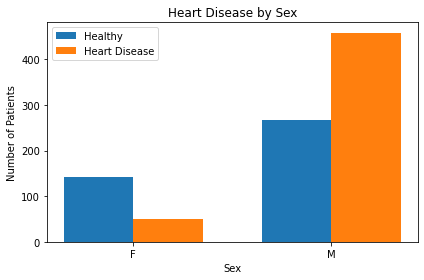

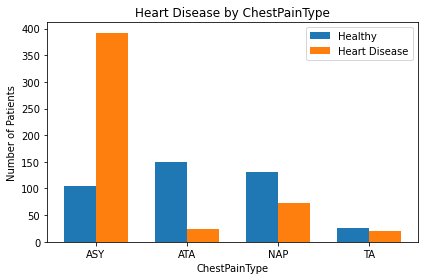

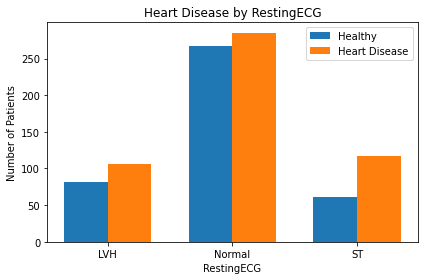

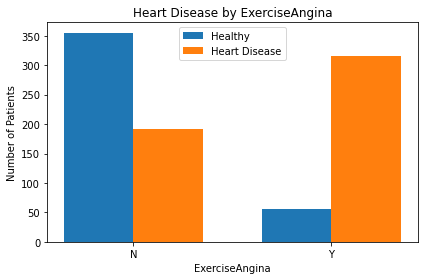

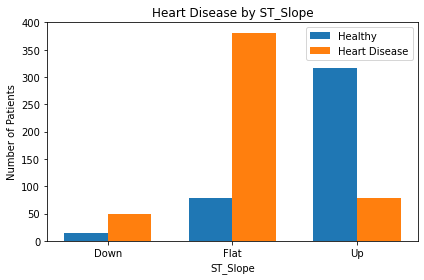

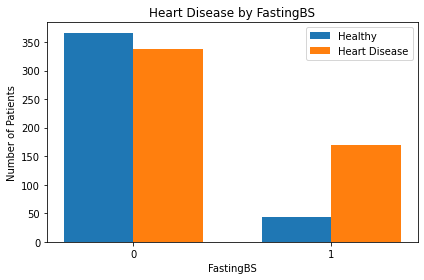

In [6]:
#plots catagoric valriables
for var in cat_vars:
    display_barchart(heart_data, var, label)

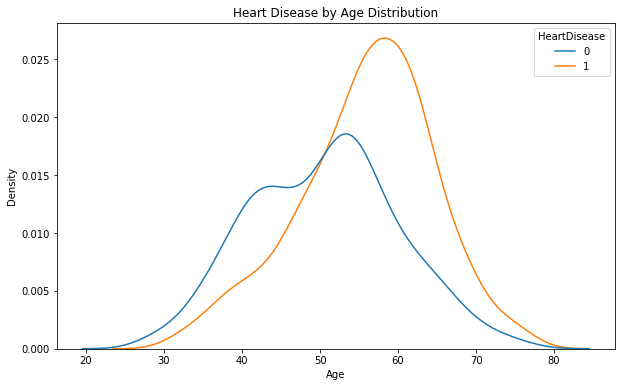

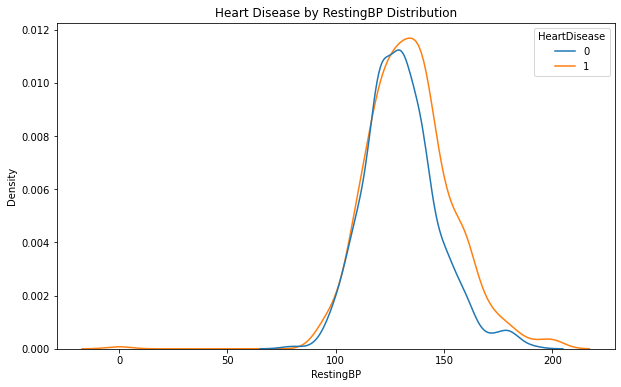

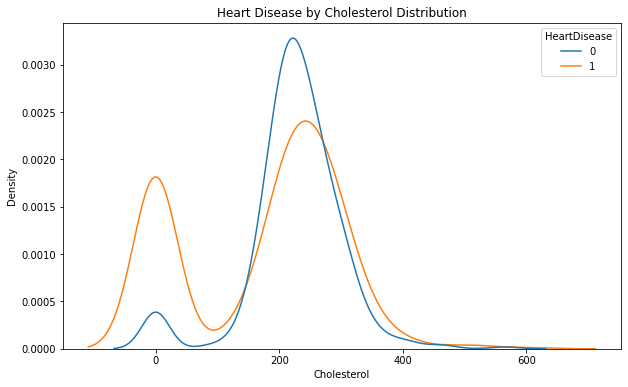

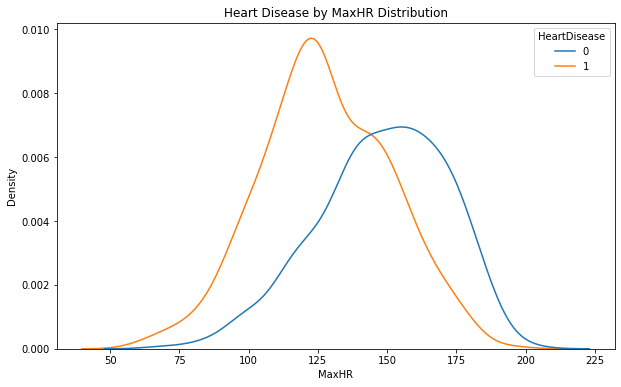

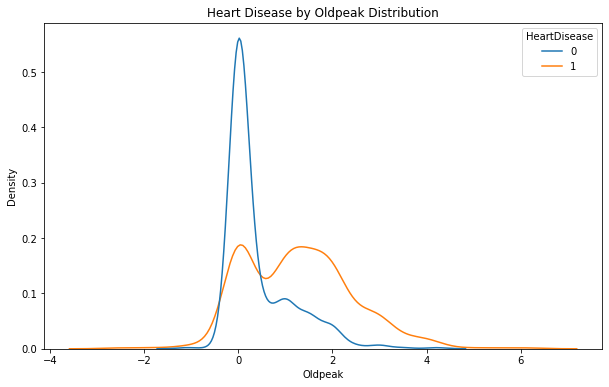

In [7]:
#plots numeric valriables
for var in num_vars:
    display_kdechart(heart_data, var, label)

In [8]:
#Missing Values (0)
#Takes care of the '0' values for RestingBP
bp_ix = heart_data[heart_data.RestingBP == 0].index[0]
bp_avg = heart_data.RestingBP.mean()
heart_data.loc[bp_ix, 'RestingBP'] =  bp_avg
#drops Cholesterol column
heart_data.drop('Cholesterol', axis=1, inplace=True)

#Encodes catagoric variables/Scales numeric variable
cat_cols = [1, 2, 5, 7, 9] #column index for catagoric variables
num_cols = [0, 3, 6, 8] #column index for numeric variables
#transforms each column based on its datatype -- columns not included are passed through
ct = ColumnTransformer([
    ('catagoric', OneHotEncoder(), cat_cols),
    ('numeric', StandardScaler(), num_cols)
    ], remainder='passthrough')
data_clean = ct.fit_transform(heart_data.values)
#displays a sample of the processed data
print('Cleaned Data:')
print(data_clean[0])

Cleaned Data:
[0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0
 -1.4331398004436657 0.4148614371130468 1.3829282169443904
 -0.832432393131704 0 0]


In [9]:
#Splits the data into train, test, validate
X, y = data_clean.T[:-1].T.astype('float32'), data_clean.T[-1].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.5,test_size=0.5, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size = 0.5,test_size=0.5, random_state=1)

#displays the amount of samples in each dataset
print('Samples in Train Set:', len(X_train))
print('Samples in Validation Set:', len(X_val))
print('Samples in Test Set:', len(X_test))

Samples in Train Set: 459
Samples in Validation Set: 229
Samples in Test Set: 230


In [19]:
#builds the architecture for a neural network
#sets the learning rate
lr = 0.001

#creates a dense network with 1 skip step
inputs = keras.Input(shape=(19,))
a = layers.Dense(24, activation='relu')(inputs)
x = layers.Dropout(0.4)(a)
x = layers.Dense(24, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.concatenate([a, x])
x = layers.Dense(24, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(1, activation='sigmoid')(x)

nn = keras.Model(inputs, output, name="heartdisease_predictor")
nn.summary()

Model: "heartdisease_predictor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 19)]         0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 24)           480         ['input_2[0][0]']                
                                                                                                  
 dropout_3 (Dropout)            (None, 24)           0           ['dense_4[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 24)           600         ['dropout_3[0][0]']              
                                                                             

In [20]:
#compiles the model with Adam optimizer
nn.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
            loss='binary_crossentropy', metrics=[BinaryAccuracy()])
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Trains the neural network
nn.fit(X_train, y_train, epochs=1000, callbacks=[early_stopper], validation_data=(X_val, y_val))

Epoch 1/1000
15/15 [==============================] - 2s 27ms/step - loss: 0.5405 - binary_accuracy: 0.7037 - val_loss: 0.4304 - val_binary_accuracy: 0.8341
Epoch 2/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.4328 - binary_accuracy: 0.8192 - val_loss: 0.4041 - val_binary_accuracy: 0.8559
Epoch 3/1000
15/15 [==============================] - 0s 11ms/step - loss: 0.3681 - binary_accuracy: 0.8519 - val_loss: 0.3776 - val_binary_accuracy: 0.8603
Epoch 4/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.3706 - binary_accuracy: 0.8584 - val_loss: 0.3732 - val_binary_accuracy: 0.8515
Epoch 5/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.3523 - binary_accuracy: 0.8606 - val_loss: 0.3800 - val_binary_accuracy: 0.8646
Epoch 6/1000
15/15 [==============================] - 0s 9ms/step - loss: 0.3216 - binary_accuracy: 0.8693 - val_loss: 0.3916 - val_binary_accuracy: 0.8603
Epoch 7/1000
15/15 [==============================] - 0s 7ms

In [21]:
#Display the metrics of the neural network on the test set
test_preds = nn.predict(X_test)
test_preds = [round(float(i), 0) for i in test_preds]
test_acc = accuracy_score(y_test, test_preds)
test_rec = recall_score(y_test, test_preds)
test_pre = precision_score(y_test, test_preds)
print('Test Set Metrics')
print('Ensemble Model Accuracy:', test_acc)

#print('Ensemble Model Recall:', test_rec)
#print('Ensemble Model Precision:', test_pre)

Test Set Metrics
Ensemble Model Accuracy: 0.8739130434782608


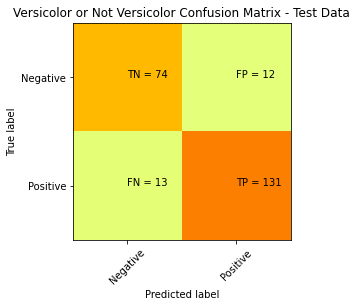

In [18]:
cm = confusion_matrix(test_preds, y_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Versicolor or Not Versicolor Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()